# This notebook is for the Fair-Shapely experiment

In [96]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [98]:
from src.data.unified_dataloader import load_dataset

a, processed_compas = load_dataset('compas')

In [99]:
processed_compas.head(3)

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,2.875313,-0.141855,-0.187414,-0.218065,-0.711240,0,0,0,0,0,1,1,0,1,0,1,0,0
1,1,-0.068808,-0.141855,-0.187414,-0.218065,-0.711240,1,0,0,0,0,0,1,0,1,0,1,0,1
2,1,-0.909985,-0.141855,-0.187414,1.775750,0.108063,1,0,0,0,0,0,1,0,1,0,1,0,1


### 3. Split label/unlabel data, split train/test data.

In [112]:
'''COMPAS'''
df = processed_compas.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

In [113]:
from src.evaluation.five_fold_cross_validation import evaluate_model
model = XGBClassifier()
evaluate_model(model=model, X_train=X, y_train=y, num_folds=5, dataset_name='compas', fairshap_base='EO')

-------------------------------------
-------------1th fold----------------
-------------------------------------
1. Split the compas dataset into majority group and minority group according to the number of sensitive attribute, besides split by label 0 and label 1
Now we assume that: g1 is majority group, g0 is minority group
X_train_majority_label0 shape: (2483, 18)
X_train_majority_label1 shape: (2187, 18)
X_train_minority_label0 shape: (703, 18)
X_train_minority_label1 shape: (398, 18)
2. 初始化FairnessExplainer
This is FairSHAP combined with EO, so we only consider the label 1
3. 计算original model在X_test上的accuracy, DR, DP, EO, PP, recall, precision, sufficiency
4. 比较eo_g1和eo_g2,然后决定优化的方向
---EO_g1: 0.5229681978798587, EO_g2: 0.47
---EO_g1 < EO_g0, 优化方向为增加EO_g1的TPR,即使得所有label=1的所有g1的数据点, 尽可能都预测为1
---因为现在minority group = g0, majority group = g1, 所以我们只对majority group进行修改
5. 将X_train_majority_label1与X_train_minority_label1进行匹配
6. 使用FairSHAP, 替换X_train_majority_label1中的数据, 从 X_train_minorit

### 4. read saved_csv file and make plots

In [1]:
def extract_original_values(fold):
    original_DR = fold.loc[0,'new_DR']
    original_DP = fold.loc[0,'new_DP']
    original_EO = fold.loc[0,'new_EO']
    original_PQP = fold.loc[0,'new_PQP']
    return original_DR, original_DP, original_EO, original_PQP

In [ ]:
import pandas as pd
import numpy as np

fold1 = pd.read_csv('saved_results/compas/1-fold_results.csv')
fold2 = pd.read_csv('saved_results/compas/2-fold_results.csv')
fold3 = pd.read_csv('saved_results/compas/3-fold_results.csv')
fold4 = pd.read_csv('saved_results/compas/4-fold_results.csv')
fold5 = pd.read_csv('saved_results/compas/5-fold_results.csv')

fold1_original_DR, fold1_original_DP, fold1_original_EO, fold1_original_PQP = extract_original_values(fold1)
fold2_original_DR, fold2_original_DP, fold2_original_EO, fold2_original_PQP = extract_original_values(fold2)
fold3_original_DR, fold3_original_DP, fold3_original_EO, fold3_original_PQP = extract_original_values(fold3)
fold4_original_DR, fold4_original_DP, fold4_original_EO, fold4_original_PQP = extract_original_values(fold4)
fold5_original_DR, fold5_original_DP, fold5_original_EO, fold5_original_PQP = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_drs = [fold1_original_DR, fold2_original_DR, fold3_original_DR, fold4_original_DR, fold5_original_DR]
original_dps = [fold1_original_DP, fold2_original_DP, fold3_original_DP, fold4_original_DP, fold5_original_DP]  
original_eos = [fold1_original_EO, fold2_original_EO, fold3_original_EO, fold4_original_EO, fold5_original_EO]
original_pqps = [fold1_original_PQP, fold2_original_PQP, fold3_original_PQP, fold4_original_PQP, fold5_original_PQP]



#### 4.1 直接plot_results

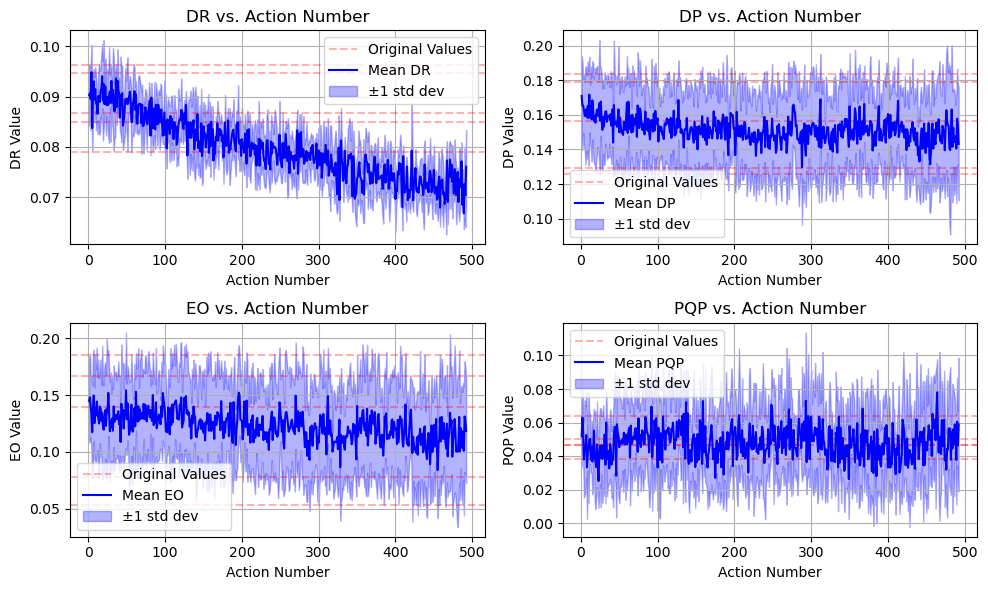

In [3]:
from src.visualization.visualization2 import plot_results

# 调用函数
plot_results(
    folds=folds,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    stop_when_no_data=3,
    min_action=1,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='b',
    red_alpha=0.3  # 红线透明度
)

#### 4.2 画图每个fold相对自己original value的提升

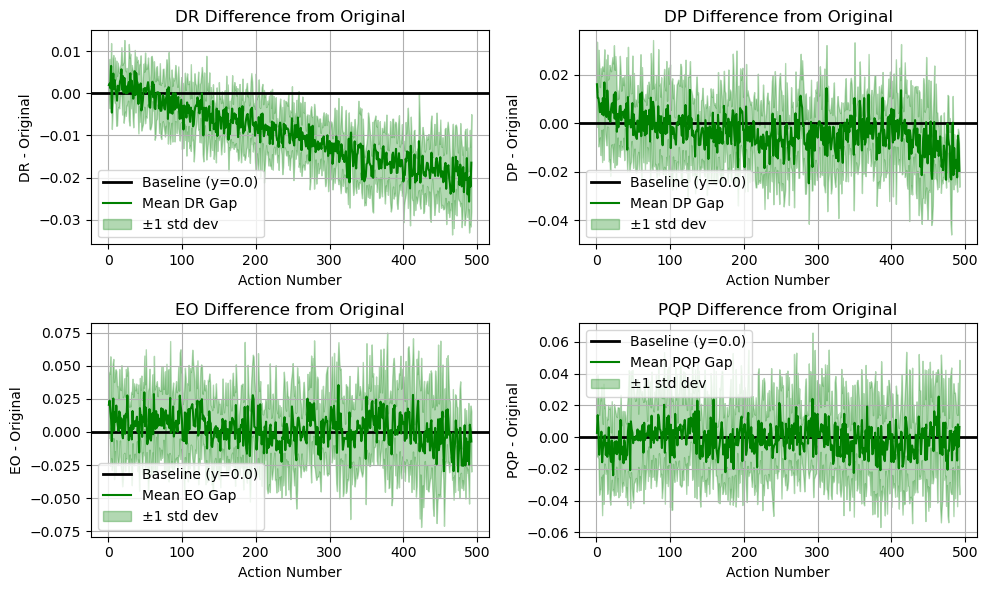

In [5]:
from src.visualization.visualization1 import plot_fairness_improvement


plot_fairness_improvement(
    folds=folds,
    original_DR=original_drs,
    original_DP=original_dps,
    original_EO=original_eos,
    original_PQP=original_pqps,
    stop_when_no_data=3,  # 当有 3 个 fold 无数据时停止
    min_action=1,
    baseline=0.0,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='g'
)

--------------

### 4.3 DP

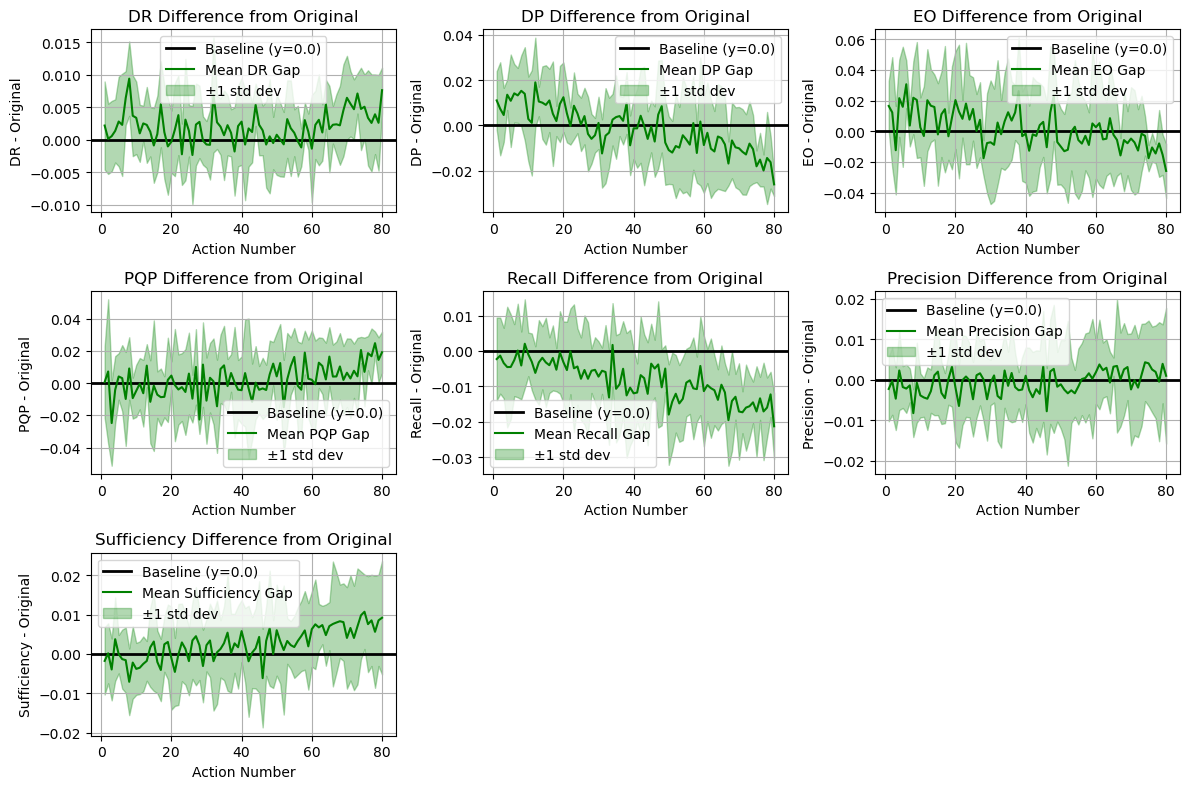

In [20]:
''' DR+precision
 alpha=0.8, DR不行
alpha=0.9
alpha=0.95, DR可以, precision不行

'''

import pandas as pd
import numpy as np

def extract_original_values(fold):
    original_DR = fold.loc[0, 'new_DR']
    original_DP = fold.loc[0, 'new_DP']
    original_EO = fold.loc[0, 'new_EO']
    original_PQP = fold.loc[0, 'new_PQP']
    original_recall = fold.loc[0, 'new_recall']
    original_precision = fold.loc[0, 'new_precision']
    original_sufficiency = fold.loc[0, 'new_sufficiency']
    return original_DR, original_DP, original_EO, original_PQP, original_recall, original_precision, original_sufficiency

fold1 = pd.read_csv('saved_results/compas/fairSHAP-DP_1-fold_results.csv')
fold2 = pd.read_csv('saved_results/compas/fairSHAP-DP_2-fold_results.csv')
fold3 = pd.read_csv('saved_results/compas/fairSHAP-DP_3-fold_results.csv')
fold4 = pd.read_csv('saved_results/compas/fairSHAP-DP_4-fold_results.csv')
fold5 = pd.read_csv('saved_results/compas/fairSHAP-DP_5-fold_results.csv')

fold1_original_values = extract_original_values(fold1)
fold2_original_values = extract_original_values(fold2)
fold3_original_values = extract_original_values(fold3)
fold4_original_values = extract_original_values(fold4)
fold5_original_values = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_drs = [fold1_original_values[0], fold2_original_values[0], fold3_original_values[0], fold4_original_values[0], fold5_original_values[0]]
original_dps = [fold1_original_values[1], fold2_original_values[1], fold3_original_values[1], fold4_original_values[1], fold5_original_values[1]]
original_eos = [fold1_original_values[2], fold2_original_values[2], fold3_original_values[2], fold4_original_values[2], fold5_original_values[2]]
original_pqps = [fold1_original_values[3], fold2_original_values[3], fold3_original_values[3], fold4_original_values[3], fold5_original_values[3]]
original_recalls = [fold1_original_values[4], fold2_original_values[4], fold3_original_values[4], fold4_original_values[4], fold5_original_values[4]]
original_precisions = [fold1_original_values[5], fold2_original_values[5], fold3_original_values[5], fold4_original_values[5], fold5_original_values[5]]
original_sufficiencies = [fold1_original_values[6], fold2_original_values[6], fold3_original_values[6], fold4_original_values[6], fold5_original_values[6]]


from src.visualization.viz3 import plot_fairness_improvement
# 调用函数
plot_fairness_improvement(
    folds=folds,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    original_recall=original_recalls,
    original_precision=original_precisions,
    original_sufficiency=original_sufficiencies,
    stop_when_no_data=3,
    min_action=1,
    figsize=(12, 8),
    fill_alpha=0.3,
    fill_color='g',

)


### 4.4 EO

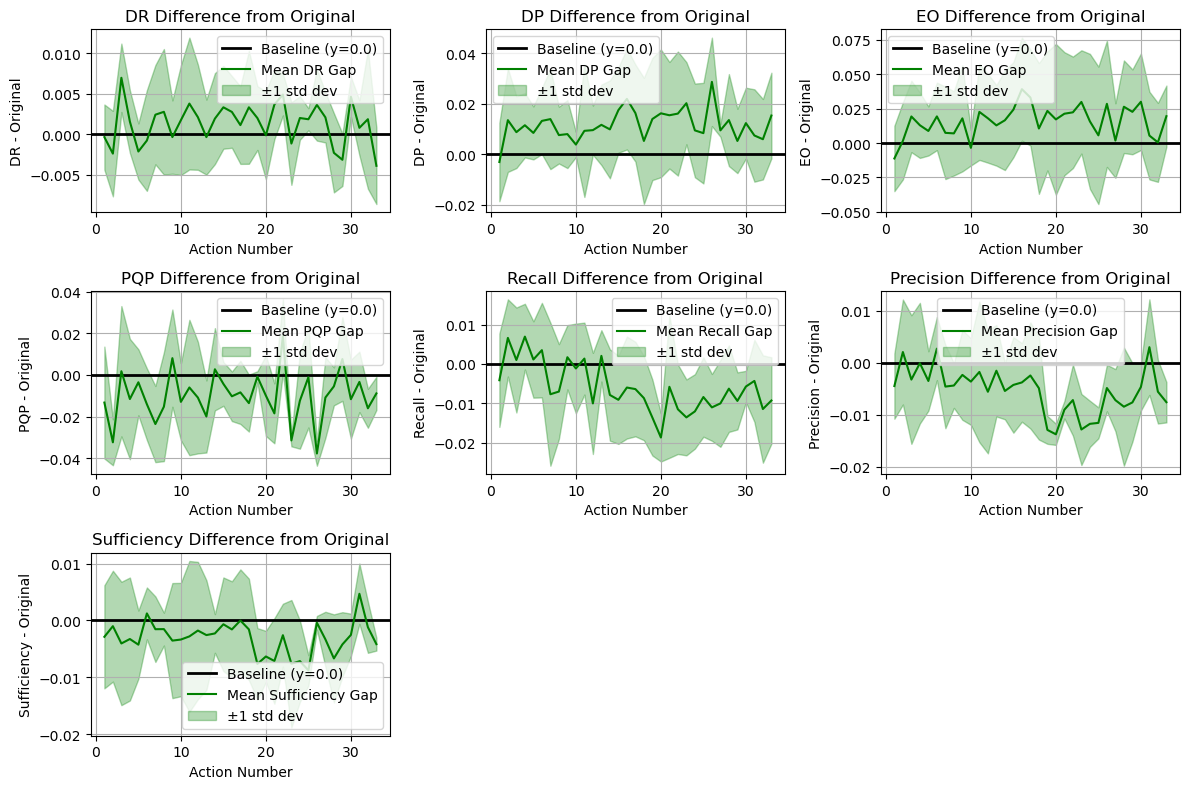

In [114]:
import pandas as pd
import numpy as np

def extract_original_values(fold):
    original_DR = fold.loc[0, 'new_DR']
    original_DP = fold.loc[0, 'new_DP']
    original_EO = fold.loc[0, 'new_EO']
    original_PQP = fold.loc[0, 'new_PQP']
    original_recall = fold.loc[0, 'new_recall']
    original_precision = fold.loc[0, 'new_precision']
    original_sufficiency = fold.loc[0, 'new_sufficiency']
    return original_DR, original_DP, original_EO, original_PQP, original_recall, original_precision, original_sufficiency

fold1 = pd.read_csv('saved_results/compas/fairSHAP-EO_1-fold_results.csv')
fold2 = pd.read_csv('saved_results/compas/fairSHAP-EO_2-fold_results.csv')
fold3 = pd.read_csv('saved_results/compas/fairSHAP-EO_3-fold_results.csv')
fold4 = pd.read_csv('saved_results/compas/fairSHAP-EO_4-fold_results.csv')
fold5 = pd.read_csv('saved_results/compas/fairSHAP-EO_5-fold_results.csv')

fold1_original_values = extract_original_values(fold1)
fold2_original_values = extract_original_values(fold2)
fold3_original_values = extract_original_values(fold3)
fold4_original_values = extract_original_values(fold4)
fold5_original_values = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_drs = [fold1_original_values[0], fold2_original_values[0], fold3_original_values[0], fold4_original_values[0], fold5_original_values[0]]
original_dps = [fold1_original_values[1], fold2_original_values[1], fold3_original_values[1], fold4_original_values[1], fold5_original_values[1]]
original_eos = [fold1_original_values[2], fold2_original_values[2], fold3_original_values[2], fold4_original_values[2], fold5_original_values[2]]
original_pqps = [fold1_original_values[3], fold2_original_values[3], fold3_original_values[3], fold4_original_values[3], fold5_original_values[3]]
original_recalls = [fold1_original_values[4], fold2_original_values[4], fold3_original_values[4], fold4_original_values[4], fold5_original_values[4]]
original_precisions = [fold1_original_values[5], fold2_original_values[5], fold3_original_values[5], fold4_original_values[5], fold5_original_values[5]]
original_sufficiencies = [fold1_original_values[6], fold2_original_values[6], fold3_original_values[6], fold4_original_values[6], fold5_original_values[6]]


from src.visualization.viz3 import plot_fairness_improvement
# 调用函数
plot_fairness_improvement(
    folds=folds,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    original_recall=original_recalls,
    original_precision=original_precisions,
    original_sufficiency=original_sufficiencies,
    stop_when_no_data=3,
    min_action=1,
    figsize=(12, 8),
    fill_alpha=0.3,
    fill_color='g',

)


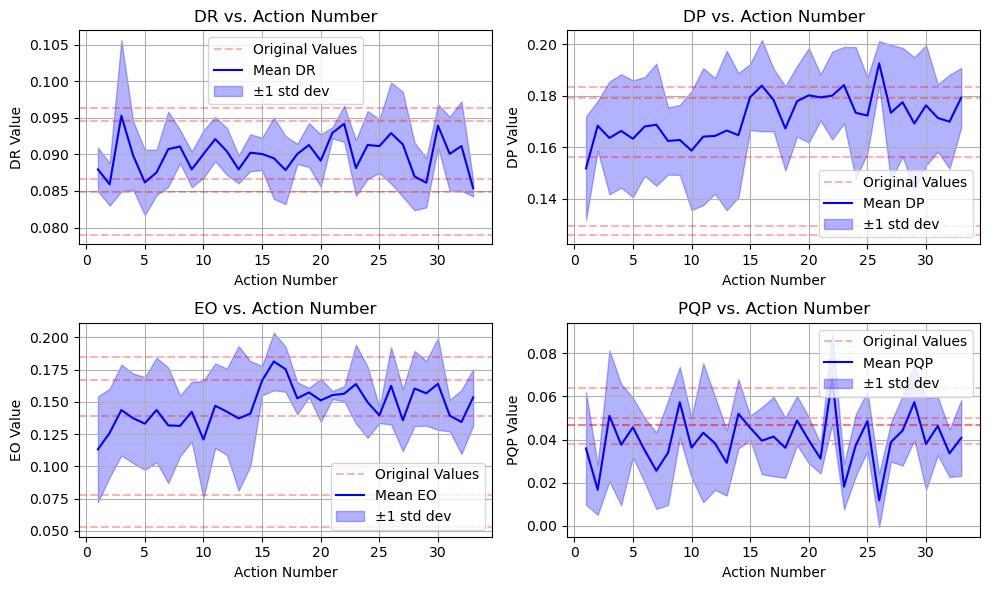

In [115]:
import pandas as pd
import numpy as np


def extract_original_values(fold):
    original_DR = fold.loc[0, 'new_DR']
    original_DP = fold.loc[0, 'new_DP']
    original_EO = fold.loc[0, 'new_EO']
    original_PQP = fold.loc[0, 'new_PQP']
    original_recall = fold.loc[0, 'new_recall']
    original_precision = fold.loc[0, 'new_precision']
    original_sufficiency = fold.loc[0, 'new_sufficiency']
    return original_DR, original_DP, original_EO, original_PQP, original_recall, original_precision, original_sufficiency

fold1 = pd.read_csv('saved_results/compas/fairSHAP-EO_1-fold_results.csv')
fold2 = pd.read_csv('saved_results/compas/fairSHAP-EO_2-fold_results.csv')
fold3 = pd.read_csv('saved_results/compas/fairSHAP-EO_3-fold_results.csv')
fold4 = pd.read_csv('saved_results/compas/fairSHAP-EO_4-fold_results.csv')
fold5 = pd.read_csv('saved_results/compas/fairSHAP-EO_5-fold_results.csv')

fold1_original_values = extract_original_values(fold1)
fold2_original_values = extract_original_values(fold2)
fold3_original_values = extract_original_values(fold3)
fold4_original_values = extract_original_values(fold4)
fold5_original_values = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_drs = [fold1_original_values[0], fold2_original_values[0], fold3_original_values[0], fold4_original_values[0], fold5_original_values[0]]
original_dps = [fold1_original_values[1], fold2_original_values[1], fold3_original_values[1], fold4_original_values[1], fold5_original_values[1]]
original_eos = [fold1_original_values[2], fold2_original_values[2], fold3_original_values[2], fold4_original_values[2], fold5_original_values[2]]
original_pqps = [fold1_original_values[3], fold2_original_values[3], fold3_original_values[3], fold4_original_values[3], fold5_original_values[3]]
original_recalls = [fold1_original_values[4], fold2_original_values[4], fold3_original_values[4], fold4_original_values[4], fold5_original_values[4]]
original_precisions = [fold1_original_values[5], fold2_original_values[5], fold3_original_values[5], fold4_original_values[5], fold5_original_values[5]]
original_sufficiencies = [fold1_original_values[6], fold2_original_values[6], fold3_original_values[6], fold4_original_values[6], fold5_original_values[6]]


from src.visualization.visualization2 import plot_results

# 调用函数
plot_results(
    folds=folds,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    stop_when_no_data=3,
    min_action=1,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='b',
    red_alpha=0.3  # 红线透明度
)
